In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
usecols = ['AGE', 'ANL_INCM', 'ANVRSRY_DATE','BIRTH_DATE','COMNCTN_IND', 'CORPRT_CD', 'Enquiry Customer Type', 'Enquiry Source',
 'Enquiry Date', 'Enquiry Type','link_Enquiry', 'link_Model', 'LOCTN_CD', 'MARTL_IND', 'MOTHER_TONGE', 'No Of Followup',
 'Occupation Desc', 'PARNT_GROP', 'PERMNT_PIN', 'Procrurement Offer Responce', 'RELGN_CD', 'RES_PIN', 'SEX_IND',
 'SORC_CD', 'Web Enquiry Flag', 'LEAD_TYPE']
parse_dates = ['ANVRSRY_DATE', 'Enquiry Date']
dtype_dict = {'AGE': 'Int8', 'ANL_INCM': 'category', 'ANVRSRY_DATE': 'str','BIRTH_DATE':'str', 'COMNCTN_IND': 'category', 'CORPRT_CD': 'category',
 'Enquiry Customer Type': 'category', 'Enquiry Source': 'category', 'Enquiry Date': 'str', 'Enquiry Type': 'category','link_Enquiry':'float64',
 'link_Model': 'object', 'LOCTN_CD': 'object', 'MARTL_IND': 'category', 'MOTHER_TONGE': 'Int8', 'No Of Followup': 'Int16',
 'Occupation Desc': 'category', 'PARNT_GROP': 'object', 'PERMNT_PIN': 'Int32', 'Procrurement Offer Responce': 'category',
 'RELGN_CD': 'category', 'RES_PIN': 'Int32', 'SEX_IND': 'category', 'SORC_CD': 'category', 'Web Enquiry Flag': 'category',
 'LEAD_TYPE': 'category'}

In [3]:
def load_Enq():
    enq = pd.read_csv("Enquiry new data.csv",
                  usecols= usecols,
#                   dtype=dtype_dict,
                  parse_dates=parse_dates,
                  nrows=100000,
                  error_bad_lines=False,
#                   na_filter=False,
                  engine='c',
                  low_memory=False)

#     csv_path=pd.read_csv("Enquiry new data.csv", encoding="Cp1252", low_memory=False,nrows=100000)
    return enq

In [4]:
def load_retail():
    csv_path=pd.read_csv("retail.csv", encoding="Cp1252", low_memory=False)
    return csv_path

In [5]:
retail=load_retail()

In [6]:
retail.shape

(298430, 33)

In [7]:
enq=load_Enq()

In [8]:
enq.ANL_INCM.value_counts()

A3    27297
A2    19022
A4     8311
A1     4464
A5     1587
Name: ANL_INCM, dtype: int64

In [9]:
enq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
AGE                            99538 non-null float64
ANL_INCM                       60681 non-null object
ANVRSRY_DATE                   63149 non-null datetime64[ns]
BIRTH_DATE                     100000 non-null object
COMNCTN_IND                    100000 non-null object
CORPRT_CD                      18509 non-null float64
Enquiry Customer Type          100000 non-null object
Enquiry Date                   100000 non-null datetime64[ns]
Enquiry Source                 100000 non-null object
Enquiry Type                   100000 non-null object
link_Enquiry                   100000 non-null int64
link_Model                     100000 non-null object
LOCTN_CD                       100000 non-null object
MARTL_IND                      89064 non-null object
MOTHER_TONGE                   71083 non-null float64
No Of Followup                 100000 non-null int64
Occupation Desc

In [10]:
len(retail)

298430

In [11]:
retail.rename(columns= {'Invoice Status':'Invoice_Status'}, inplace=True)

In [12]:
pd.options.display.max_columns=None

In [13]:
#to check if enquiry is present in retail table (Y lable)
def checkInRetail(row):
    if row["link_Enquiry_enq"]==row["link_Enquiry"]:
        return 1
    else:
        return 0
    

In [14]:
#converting objects to date format
enq["ANVRSRY_DATE"]=pd.to_datetime(enq["ANVRSRY_DATE"], errors = 'coerce')
#enq["ANVRSRY_DATE"]=enq["ANVRSRY_DATE"].dt.strftime('%d-%m-%Y')
enq["Enquiry Date"]=pd.to_datetime(enq["Enquiry Date"])
#enq["Enquiry Date"]=enq["Enquiry Date"].dt.strftime('%d-%m-%Y')
enq["BIRTH_DATE"]=pd.to_datetime(enq["BIRTH_DATE"])
#enq["BIRTH_DATE"]=enq["BIRTH_DATE"].dt.strftime('%d-%m-%Y')
#enq["Enquiry Date"].head(5)
#enq["ANVRSRY_DATE"].head(5)
#enq["BIRTH_DATE"].head(1)

In [15]:
# to check if enquiry was made near birth/anniversary date
def anniversaryVsBirthVsEnquiryDate(row):
    
#(enq["BIRTH_DATE"]-enq["Enquiry Date"]).astype('<m8[M]')
   return (1 if (abs(row["BIRTH_DATE"].month - row["Enquiry Date"].month)<=2 or \
           abs(row["ANVRSRY_DATE"].month - row["Enquiry Date"].month)<=2) else 0)
        
        
enq["celebration"]=enq.apply(anniversaryVsBirthVsEnquiryDate,axis=1)



In [16]:
enq.dropna(subset=['ANL_INCM'],inplace=True)

In [17]:
enq["celebration"].value_counts()

1    30387
0    30294
Name: celebration, dtype: int64

In [18]:
enq.rename(columns={"link_Enquiry":"link_Enquiry_enq"}, inplace=True)
# retail=retail.query("Invoice_Type=='CI' and Invoice_Status=='Invoiced'")
enq=pd.merge(enq,retail.link_Enquiry.to_frame(),left_on=["link_Enquiry_enq"], right_on=["link_Enquiry"],how="left")


In [112]:
# len(enq[enq['link_Enquiry_enq'].isin(retail.link_Enquiry)])

In [19]:
enq["result"]=enq.apply(checkInRetail,axis=1)

In [20]:
enq["models"]=enq["link_Model"].str[:4]
enq["result"].value_counts()

0    40468
1    22526
Name: result, dtype: int64

In [21]:
enq

,AGE,ANL_INCM,ANVRSRY_DATE,BIRTH_DATE,COMNCTN_IND,CORPRT_CD,Enquiry Customer Type,Enquiry Date,Enquiry Source,Enquiry Type,link_Enquiry_enq,link_Model,LOCTN_CD,MARTL_IND,MOTHER_TONGE,No Of Followup,Occupation Desc,PARNT_GROP,PERMNT_PIN,Procrurement Offer Responce,RELGN_CD,RES_PIN,SEX_IND,SORC_CD,Web Enquiry Flag,LEAD_TYPE,celebration,link_Enquiry,result,models
0,1.0,A2,2018-05-15,2017-06-15,OFC,9999.0,Corporate,2018-06-30,Newspaper,Walk-in,51099833,JETOMM316811167,MK01,M,2.0,2,Salaried-Others,MAK01,NaN,Rejected,H,NaN,M,NWP,Non-CW,WLK,1,51099833.0,1,JETO
1,1.0,A2,NaT,2017-01-07,PRM,NaN,Individual,2018-09-20,DSA / DMA,Field,52313381,MRZOMM6210000034,TS17,S,6.0,2,Salaried-Others,TVS01,695542.0,Rejected,H,695542.0,M,DSA,Non-CW,FLD,0,52313381.0,1,MRZO
2,1.0,A2,NaT,2017-01-07,PRM,NaN,Individual,2018-09-20,DSA / DMA,Field,52313381,MRZOMM6210000034,TS17,S,6.0,2,Salaried-Others,TVS01,695542.0,Rejected,H,695542.0,M,DSA,Non-CW,FLD,0,52313381.0,1,MRZO
3,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-10-02,Newspaper,Walk-in,49257332,BOLPMM4881045187,AR02,NaN,2.0,2,Business,AR001,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49257332.0,1,BOLP
4,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-02-13,Newspaper,Walk-in,49287918,BOLPMM4881045187,AR02,NaN,2.0,3,Business,AR001,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49287918.0,1,BOLP
5,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-02-13,Newspaper,Walk-in,49287918,BOLPMM4881045187,AR02,NaN,2.0,3,Business,AR001,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49287918.0,1,BOLP
6,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-02-13,Newspaper,Walk-in,49287918,BOLPMM4881045187,AR02,NaN,2.0,3,Business,AR001,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49287918.0,1,BOLP
7,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-02-13,Newspaper,Walk-in,49287918,BOLPMM4881045187,AR02,NaN,2.0,3,Business,AR001,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49287918.0,1,BOLP
8,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-02-13,Newspaper,Walk-in,49287918,BOLPMM4881045187,AR02,NaN,2.0,3,Business,AR001,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49287918.0,1,BOLP
9,1.0,A3,NaT,2017-06-27,RES,9999.0,Corporate,2018-02-13,Newspaper,Walk-in,49287918,BOLPMM4881045187,AR02,NaN,2.0,3,Business,AR001,281005.0,Rejected,H,281005.0,M,NWP,Non-CW,WLK,0,49287918.0,1,BOLP


In [22]:
#enq.head(10)
test1=enq.query("celebration=='1'")
test1["result"].value_counts()

0    20232
1    11256
Name: result, dtype: int64

AttributeError: 'Series' object has no attribute 'to_list'

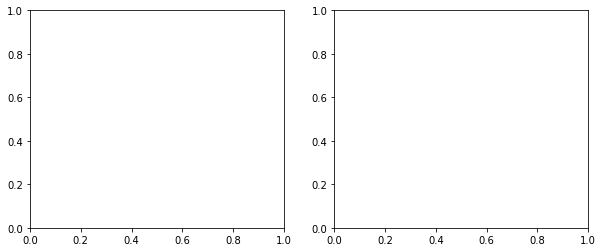

In [117]:
survived = 'Purhased'
not_survived = 'not Purchased'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = enq[enq['SEX_IND']=='F']
men = enq[enq['SEX_IND']=='M']
# women[women['result']==1].AGE.dropna()
ax = sns.distplot(women[women['result']==1].AGE.dropna().to_list(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['result']==0].AGE.dropna().to_list(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['result']==1].AGE.dropna().to_list(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['result']==0].AGE.dropna().to_list(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

In [23]:
# to impute null fields of AGE column
mean=enq["AGE"].mean()
std=enq["AGE"].std()

is_null = (~enq["AGE"].notnull()).sum()
# compute random numbers between the mean, std and is_null
rand_age=np.random.randint(mean-std,mean+std,size=is_null)
age_slice=enq["AGE"].copy()
age_slice[~enq.AGE.notnull()]=rand_age
# print(rand_age)
# break
enq["AGE"]=age_slice

In [24]:
len(enq)

62994

-0.2 12551 0.20
0.8 18897 0.30
1.8 5273 0.08
2.8 905 0.01
3.8 2857 0.05
0.2 6960 0.11
1.2 9398 0.15
2.2 3606 0.06
3.2 834 0.01
4.2 1743 0.03


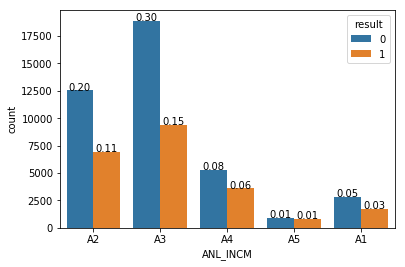

In [25]:
total =len(enq["ANL_INCM"])
ax = sns.countplot(x="ANL_INCM",hue="result",data=enq)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
    print(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total))

In [26]:
finalEnq=enq.drop(columns=['ANVRSRY_DATE','BIRTH_DATE','CORPRT_CD','Enquiry Date','link_Model','PARNT_GROP','PERMNT_PIN','RES_PIN','link_Enquiry_enq','link_Enquiry'],axis=1)

In [27]:
names=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90>']
bins=[0,10,20,30,40,50,60,70,80,90]
d = dict(enumerate(names, 1))

finalEnq['AgeRange'] = np.vectorize(d.get)(np.digitize(finalEnq['AGE'], bins))

In [28]:
finalEnq["AgeRange"]=finalEnq["AgeRange"].astype('category')
finalEnq.drop('AGE',axis=1,inplace=True)

In [29]:
finalEnq

,ANL_INCM,COMNCTN_IND,Enquiry Customer Type,Enquiry Source,Enquiry Type,LOCTN_CD,MARTL_IND,MOTHER_TONGE,No Of Followup,Occupation Desc,Procrurement Offer Responce,RELGN_CD,SEX_IND,SORC_CD,Web Enquiry Flag,LEAD_TYPE,celebration,result,models,AgeRange
0,A2,OFC,Corporate,Newspaper,Walk-in,MK01,M,2.0,2,Salaried-Others,Rejected,H,M,NWP,Non-CW,WLK,1,1,JETO,0-10
1,A2,PRM,Individual,DSA / DMA,Field,TS17,S,6.0,2,Salaried-Others,Rejected,H,M,DSA,Non-CW,FLD,0,1,MRZO,0-10
2,A2,PRM,Individual,DSA / DMA,Field,TS17,S,6.0,2,Salaried-Others,Rejected,H,M,DSA,Non-CW,FLD,0,1,MRZO,0-10
3,A3,RES,Corporate,Newspaper,Walk-in,AR02,NaN,2.0,2,Business,Rejected,H,M,NWP,Non-CW,WLK,0,1,BOLP,0-10
4,A3,RES,Corporate,Newspaper,Walk-in,AR02,NaN,2.0,3,Business,Rejected,H,M,NWP,Non-CW,WLK,0,1,BOLP,0-10
5,A3,RES,Corporate,Newspaper,Walk-in,AR02,NaN,2.0,3,Business,Rejected,H,M,NWP,Non-CW,WLK,0,1,BOLP,0-10
6,A3,RES,Corporate,Newspaper,Walk-in,AR02,NaN,2.0,3,Business,Rejected,H,M,NWP,Non-CW,WLK,0,1,BOLP,0-10
7,A3,RES,Corporate,Newspaper,Walk-in,AR02,NaN,2.0,3,Business,Rejected,H,M,NWP,Non-CW,WLK,0,1,BOLP,0-10
8,A3,RES,Corporate,Newspaper,Walk-in,AR02,NaN,2.0,3,Business,Rejected,H,M,NWP,Non-CW,WLK,0,1,BOLP,0-10
9,A3,RES,Corporate,Newspaper,Walk-in,AR02,NaN,2.0,3,Business,Rejected,H,M,NWP,Non-CW,WLK,0,1,BOLP,0-10


In [30]:
"Enquiry Source","LOCTN_CD","No Of Followup","SORC_CD","models"

('Enquiry Source', 'LOCTN_CD', 'No Of Followup', 'SORC_CD', 'models')

In [31]:
#removing Location cd having less than or equal to 5 occurences  in the data set
lc = pd.DataFrame(enq["LOCTN_CD"].value_counts()<=5)

# lc.reset_index(inplace=True)
filterLocn=lc[lc["LOCTN_CD"]==True].index

finalEnq.drop(index=finalEnq[finalEnq['LOCTN_CD'].isin(filterLocn)].index, axis=0,inplace=True)

In [32]:
#removing models having less than or equal to 5 occurences  in the data set
mod = pd.DataFrame(enq["models"].value_counts()<=5)
# lc.reset_index(inplace=True)
filterMod=mod[mod["models"]==True].index

finalEnq.drop(index=finalEnq[finalEnq['models'].isin(filterMod)].index, axis=0,inplace=True)

In [33]:
#removing Location cd having less than or equal to 5 occurences  in the data set
lc = pd.DataFrame(enq["Enquiry Source"].value_counts()<=5)

# lc.reset_index(inplace=True)
filterLocn=lc[lc["Enquiry Source"]==True].index

finalEnq.drop(index=finalEnq[finalEnq['Enquiry Source'].isin(filterLocn)].index, axis=0,inplace=True)

In [34]:
#removing Location cd having less than or equal to 5 occurences  in the data set
lc = pd.DataFrame(enq["No Of Followup"].value_counts()<=5)

# lc.reset_index(inplace=True)
filterLocn=lc[lc["No Of Followup"]==True].index

finalEnq.drop(index=finalEnq[finalEnq['No Of Followup'].isin(filterLocn)].index, axis=0,inplace=True)

In [35]:
#removing Location cd having less than or equal to 5 occurences  in the data set
lc = pd.DataFrame(enq["SORC_CD"].value_counts()<=5)

# lc.reset_index(inplace=True)
filterLocn=lc[lc["SORC_CD"]==True].index

finalEnq.drop(index=finalEnq[finalEnq['SORC_CD'].isin(filterLocn)].index, axis=0,inplace=True)

In [36]:
len(finalEnq)

62766

In [37]:
finalEnq["models"]=finalEnq["models"].astype('category')
finalEnq["LOCTN_CD"]=finalEnq["LOCTN_CD"].astype('category')

In [38]:
finalEnq["models"].nunique()

38

In [39]:
df_plot = finalEnq.groupby(['LOCTN_CD', 'result']).size().reset_index().pivot(columns='result', index='LOCTN_CD', values=0)
#df_plot.plot(kind='bar',stacked=True)

In [40]:
finalEnq.describe()

,MOTHER_TONGE,No Of Followup,celebration,result
count,56521.000000,62766.000000,62766.000000,62766.000000
mean,4.095044,3.730587,0.499968,0.357614
std,2.678244,3.063996,0.500004,0.479301
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000
50%,2.000000,3.000000,0.000000,0.000000
75%,6.000000,4.000000,1.000000,1.000000
max,10.000000,33.000000,1.000000,1.000000


In [41]:
finalEnq_corr=finalEnq.corr()
finalEnq_corr["result"].sort_values(ascending=False)

result            1.000000
No Of Followup    0.070553
celebration      -0.000152
MOTHER_TONGE     -0.010440
Name: result, dtype: float64

In [42]:
finalEnq.assign(SORC_CD=finalEnq.SORC_CD.astype('category').cat.codes).corr()

,MOTHER_TONGE,No Of Followup,SORC_CD,celebration,result
MOTHER_TONGE,1.000000,-0.117316,0.015113,0.004825,-0.010440
No Of Followup,-0.117316,1.000000,-0.006436,0.010300,0.070553
SORC_CD,0.015113,-0.006436,1.000000,-0.006527,0.036536
celebration,0.004825,0.010300,-0.006527,1.000000,-0.000152
result,-0.010440,0.070553,0.036536,-0.000152,1.000000


In [43]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [44]:
from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["AGE", "No Of Followup"])),
        ("imputer", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler())        
    ])

In [45]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

In [46]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [47]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["ANL_INCM","COMNCTN_IND", "Enquiry Customer Type", "Enquiry Source","Enquiry Type","MARTL_IND","MOTHER_TONGE","Occupation Desc","Procrurement Offer Responce","RELGN_CD","SEX_IND","SORC_CD","Web Enquiry Flag","LEAD_TYPE","celebration","models","AgeRange"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [48]:
finalEnq = finalEnq.apply(lambda x: x.fillna(x.value_counts().index[0]))


In [49]:
finalEnq["models"].value_counts()

PUPM    11633
BOLP     6673
SCRN     6130
MAXI     6034
ALFP     5266
JETO     4311
SUMT     2701
TUV3     2368
XUVN     2311
KUVN     2210
ALPL     2068
BOLM     1940
MRZO     1671
SUPL     1415
JETP     1384
XYLO      742
XUVR      676
THAR      593
SUMV      423
SUPP      415
TUVP      354
KUV1      325
ALFE      319
MXMH      257
IMPR      149
ALFL      126
SSHT       55
ALTS       44
XUV9       42
LOGN       30
X300       21
MXMP       18
E2OM       18
MXMO       12
REXT       10
ESPV        9
E2OP        7
NUSP        6
Name: models, dtype: int64

In [50]:
x = finalEnq.drop('result', axis=1)
y = finalEnq['result']

In [146]:
finalEnq.to_csv("final_data.csv")

PermissionError: [Errno 13] Permission denied: 'final_data.csv'

In [147]:
len(x)

62766

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=42)

In [52]:
for i in range(len(x_test.columns)):
    print("-------",x_test.columns[i])
    print(x_test.iloc[:,i].value_counts())

------- ANL_INCM
A3    8365
A2    5868
A4    2672
A1    1400
A5     525
Name: ANL_INCM, dtype: int64
------- COMNCTN_IND
RES    13105
PRM     5448
OFC      277
Name: COMNCTN_IND, dtype: int64
------- Enquiry Customer Type
Individual    15389
Corporate      3441
Name: Enquiry Customer Type, dtype: int64
------- Enquiry Source
Unplanned Activity                    4687
Newspaper                             4625
DSA / DMA                             3365
Reference                             1527
Television                            1489
Planned Campaign/Event                 610
Mitra Technician                       419
Mitra Saathi                           355
Workshop as Promoter                   324
M2ALL                                  306
Broker                                 205
Website                                136
MRC                                    120
Other Website                          108
Mitra Other                             94
Mitra Pradhan               

In [53]:
finalEnq_corr=finalEnq.corr()
finalEnq_corr["result"].sort_values(ascending=False)

result            1.000000
No Of Followup    0.070553
celebration      -0.000152
MOTHER_TONGE     -0.027308
Name: result, dtype: float64

In [54]:
finalEnq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62766 entries, 0 to 62993
Data columns (total 20 columns):
ANL_INCM                       62766 non-null object
COMNCTN_IND                    62766 non-null object
Enquiry Customer Type          62766 non-null object
Enquiry Source                 62766 non-null object
Enquiry Type                   62766 non-null object
LOCTN_CD                       62766 non-null category
MARTL_IND                      62766 non-null object
MOTHER_TONGE                   62766 non-null float64
No Of Followup                 62766 non-null int64
Occupation Desc                62766 non-null object
Procrurement Offer Responce    62766 non-null object
RELGN_CD                       62766 non-null object
SEX_IND                        62766 non-null object
SORC_CD                        62766 non-null object
Web Enquiry Flag               62766 non-null object
LEAD_TYPE                      62766 non-null object
celebration                    62766 non-

In [55]:
# num_pipeline.fit_transform(x_train)

In [56]:
cat_pipeline.fit_transform(x_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [57]:
full_pipeline=FeatureUnion(transformer_list=[
    ("cat_pipeline",cat_pipeline),
])

In [58]:
X_train=full_pipeline.fit_transform(x_train)

In [59]:
X_test = cat_pipeline.transform(x_test)

In [ ]:
# from sklearn.svm import SVC

# svm_clf = SVC(gamma="auto")
# svm_clf.fit(X_train, y_train)

In [72]:
X_test = full_pipeline.transform(x_test)

y_pred = svm_clf.predict(X_test)

In [242]:
svm_clf.score(X_test,y_test)

0.6954177897574124

In [73]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred)

0.694954859267127

In [243]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

KeyboardInterrupt: 

In [60]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=3)
forest_scores.mean()

0.7561680771677616

In [61]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [62]:
y_pred_forest=forest.predict(X_test)

In [63]:
forest.score(X_test,y_test)

0.7669144981412639

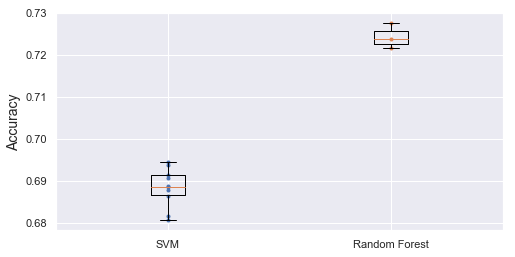

In [464]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*3, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [99]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_forest)

array([[10474,  1572],
       [ 2785,  3999]], dtype=int64)

In [100]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred_forest)

0.7686139139670738

In [107]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred_forest)

0.7178244480344642

In [108]:
recall_score(y_test, y_pred_forest)

0.5894752358490566

In [103]:
from sklearn.metrics import  classification_report
  
print(classification_report(y_test,y_pred_forest))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83     12046
           1       0.72      0.59      0.65      6784

   micro avg       0.77      0.77      0.77     18830
   macro avg       0.75      0.73      0.74     18830
weighted avg       0.76      0.77      0.76     18830



In [ ]:
svm = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':(1,0.25,0.5,0.75),'gamma': (1,2,3,'auto'),'decision_function_shape':('ovo','ovr'),'shrinking':(True,False)}
clf = GridSearchCV(svm, parameters)
clf.fit(X_train,y_train)
print("accuracy:"+str(np.average(cross_val_score(clf, X_train, y_train, scoring='accuracy'))))
print("f1:"+str(np.average(cross_val_score(clf, X_train, y_train, scoring='f1'))))

C:\Users\saicharan.pallati\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [453]:
num_pipeline.fit_transform(x_test)
cat_pipeline.fit_transform(x_test)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [454]:
X_test=full_pipeline.fit_transform(x_test)

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [28]:
def create_baseline():
	# create model
    model = Sequential()
    model.add(Dense(60, input_dim=60, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [31]:

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [32]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, x_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

NameError: name 'X_train' is not defined

In [261]:
model = Sequential()
model.add(Dense(12, input_dim=150, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.add(LSTM())
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, validation_split=0.33, epochs=150, batch_size=10)

Train on 48718 samples, validate on 23996 samples
Epoch 1/150
48718/48718 [==============================] - 10s 212us/step - loss: 0.5823 - acc: 0.6928 - val_loss: 0.5733 - val_acc: 0.6937
Epoch 2/150
48718/48718 [==============================] - 9s 175us/step - loss: 0.5611 - acc: 0.7070 - val_loss: 0.5639 - val_acc: 0.7054
Epoch 3/150
48718/48718 [==============================] - 9s 175us/step - loss: 0.5563 - acc: 0.7114 - val_loss: 0.5636 - val_acc: 0.7065
Epoch 4/150
48718/48718 [==============================] - 9s 179us/step - loss: 0.5519 - acc: 0.7143 - val_loss: 0.5603 - val_acc: 0.7054
Epoch 5/150
48718/48718 [==============================] - 9s 181us/step - loss: 0.5499 - acc: 0.7184 - val_loss: 0.5602 - val_acc: 0.7081
Epoch 6/150
48718/48718 [==============================] - 9s 184us/step - loss: 0.5470 - acc: 0.7181 - val_loss: 0.5580 - val_acc: 0.7082
Epoch 7/150
48718/48718 [==============================] - 9s 195us/step - loss: 0.5449 - acc: 0.7205 - val_loss: 0

KeyboardInterrupt: 

In [270]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X_train, y_train):
  # create model
    model = Sequential()
    model.add(Dense(12, input_dim=150, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train, y_train, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))


KeyboardInterrupt: 

In [277]:
random_x=np.random.randint(1,101,100)

In [278]:
random_x

array([ 49,  93,  82,  17,  33,  27,  39,  75,  80,  94,  92,  70,   6,
        78,  50,  69,  17,  53,  67,  39,  49,  82,  29, 100,  75,  53,
        72,  93,  91,  61,  89,  54,  68,  17,  82,  58,  61,   1,  26,
        61,  12,  21,  45,  23,  36,  41,  71,  48,  21,  77,  17,  16,
        93,  35,   8,  48,  77,  49,  89,  73,  36, 100,  48,  67,  51,
        47,  83,  76,  99,  60,  32,   4,  21,  60,  36,  27,   3,  63,
        61,  18,  31,  33,  30,  47,  70,  75,  41,  77,  22,  65,   9,
        19,  10,  29,  62,  70,  26,  59,  95,  61])